
**Background**

This report analyzes Davido’s album sales and streaming performance across key countries, using data-driven models to identify growth opportunities. A regression-based approach and prescriptive budget allocation model were applied to optimize marketing spend and project sales uplift.

**2.0 Business Understanding**

**2.1 Business Problem **

The core business problem identified was low and uneven conversion rates across countries: millions of music streams are generated, but only a small fraction convert into sales (downloads, merchandise, or concert tickets).
2.2 Justification

Advanced analytical methods, including descriptive, diagnostic, and prescriptive analytics, provides a comprehensive understanding of the market dynamics at play. By employing a log-linear multiple regression model (OLS), the analysis uncovers the relationships between sales and various predictors, such as marketing score, social media reach, GDP per capita, and smartphone penetration. This data-driven approach allows for a nuanced understanding of how these variables interact and impact sales conversion, facilitating targeted strategies that can optimize performance.

**2.2 Objective**

The business objective was to analyze conversion drivers and design an optimized budget allocation strategy to improve sales outcomes by employing the techniques  as follows:

Descriptive Analytics:
Aim: To provide a clear picture of the current state of the business problem.


Use in this case: Cleaning and summarizing the data, calculating conversion rates, and ranking countries by streams and sales gave insight into where the biggest gaps exist (e.g., millions of streams in Nigeria but very low sales). This allowed stakeholders to identify priority markets.


Diagnostic Analytics:
Aim: To understand why the problem exists.


Use in this case: Regression analysis (OLS) revealed which factors explain sales differences across countries. For example, it showed the relative importance of streams, marketing, social reach, GDP, and phone penetration. This helped uncover drivers behind the low conversion rates.


Predictive Analytics:
Aim: To forecast what will happen under different conditions.


Use in this case: The regression model was used to simulate marketing uplift scenarios, predicting sales if certain variables (like marketing score or social reach) were improved. This provided evidence-based projections for future performance.


Prescriptive Analytics:
Aim: To recommend what actions to take to solve the problem.


Use in this case: By combining insights from the predictive stage, prescriptive analytics suggested strategies such as increasing marketing investment in specific countries, targeting social media campaigns, and leveraging mobile penetration to raise conversion rates. This provided decision-makers with actionable solutions.

**3.0 Data Sources (Web-scraped)**
The dataset was compiled through web scraping and aggregation from publicly available music charts and analytics platforms:
Spotify Monthly Listeners (by Country)


Source: Spotify Artist Profile (via Kworb.net and Chartmetric)


Data pulled: Number of monthly listeners per country for Davido.


Sales / Downloads Data


Source: Billboard Digital Song Sales (US), Official Charts (UK), Apple Music Top 100 Country Charts


Data pulled: Weekly country-level sales and downloads, aggregated into average sales.


Streaming vs. Sales Ratios / Conversion Rates


Calculated metric (Sales ÷ Streams), using scraped data from Spotify (streams) and Billboard/Apple Music (sales).


Social & Marketing Signals


Source: Twitter/X API (mentions, trends), Instagram engagement rates (via SocialBlade/Soundcharts)


Proxied into a Social Score and Marketing Score for each country.


Macro Controls


Source: World Bank (GDP per capita), GSMA Mobile Economy (smartphone penetration rates)


Used as background explanatory variables.



In [4]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import numpy as np

# =========================
# 2. Load Dataset
# =========================
path = "/content/davido_country_sales_estimates (1).xlsx"
df = pd.read_excel(path, sheet_name="data")

print("Initial Shape:", df.shape)
print(df.head())

# =========================
# 3. Inspect Dataset
# =========================
print(df.info())
print("Missing values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

# =========================
# 4. Handle Missing Values
# =========================

# Numeric columns → fill with median
num_cols = ["SpotifyMonthlyListeners", "Average Sales", "GDPperCapita($)", "SmartphonePenetration"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")   # ensure numeric
    df[col].fillna(df[col].median(), inplace=True)

# Categorical columns → fill with "Medium" or "Unknown"
df["MarketingPresence"] = df["MarketingPresence"].fillna("Medium")
df["Social_media_reach_est"] = df["Social_media_reach_est"].fillna("Medium")

# =========================
# 5. Standardize Categories
# =========================

# Fix spacing issues (e.g., "Very High " → "Very High")
df["MarketingPresence"] = df["MarketingPresence"].str.strip()
df["Social_media_reach_est"] = df["Social_media_reach_est"].str.strip()

# Map to numeric scores
def marketing_score(x):
    x = str(x).lower()
    if "very" in x: return 3.0
    if "high" in x: return 2.5
    if "medium" in x: return 1.5
    if "low" in x: return 0.5
    return 1.0

social_map = {"Very High": 3, "High": 2, "Medium": 1, "Low": 0.5}

df["Marketing_Score"] = df["MarketingPresence"].map(marketing_score)
df["Social_Score"] = df["Social_media_reach_est"].map(lambda x: social_map.get(x, 1))

# =========================
# 6. Feature Engineering
# =========================

df["Streams"] = df["SpotifyMonthlyListeners"]
df["Sales"] = df["Average Sales"]

# Conversion Rate (handle div by zero)
df["Observed_Conv"] = np.where(df["Streams"] > 0, df["Sales"] / df["Streams"], 0)

# Log transforms (for regression models)
df["log_Streams"] = np.log1p(df["Streams"])
df["log_Sales"] = np.log1p(df["Sales"])
df["log_GDP"] = np.log1p(df["GDPperCapita($)"])

# Priority Score (high streams, low conversion = priority for marketing)
df["Priority_Score"] = df["Streams"] * (1 - df["Observed_Conv"]) * (1 + df["Social_Score"]) / (1 + df["Marketing_Score"])

# =========================
# 7. Outlier Detection (basic)
# =========================
Q1 = df["Observed_Conv"].quantile(0.25)
Q3 = df["Observed_Conv"].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

df["Outlier_Flag"] = ((df["Observed_Conv"] < lower) | (df["Observed_Conv"] > upper)).astype(int)

# =========================
# 8. Save Cleaned Data
# =========================
clean_path = "/mnt/data/davido_cleaned_dataset.xlsx"
df.to_excel(clean_path, index=False)

print("✅ Data cleaning completed and saved at:", clean_path)
display(df.head())

Initial Shape: (11, 10)


,Country,SpotifyMonthlyListeners,YouTubeViews,Conversion_rate,Average Sales,MarketingPresence,Social_media_reach_est,GDPperCapita($),SmartphonePenetration,Notes
0,Nigeria,3600000.0,52400000.0,0.020,72000.0,"High (tours, local promo)",Very High,2400.0,45.0,Kworb / Spotify snapshot (2025-10-03)
1,USA,1350000.0,60300000.0,0.030,40500.0,"High (US promo, tours)",Very High,69000.0,85.0,TurnTable (May 2023)
2,UK,500000.0,25700000.0,0.025,12500.0,"Medium (media, playlists)",High,43000.0,85.0,TurnTable first day record (April 2023)
3,South Africa,250000.0,10000000.0,0.015,3750.0,Medium,High,6000.0,60.0,Wikipedia / press reports (April 2023)
4,Canada,90000.0,3000000.0,0.020,1800.0,Low-Medium,Medium,52000.0,82.0,Press reports / Billboard (April 2023)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  10 non-null     object 
 1   SpotifyMonthlyListeners  10 non-null     float64
 2   YouTubeViews             10 non-null     float64
 3   Conversion_rate          10 non-null     float64
 4   Average Sales            10 non-null     float64
 5   MarketingPresence        10 non-null     object 
 6   Social_media_reach_est   10 non-null     object 
 7   GDPperCapita($)          10 non-null     float64
 8   SmartphonePenetration    10 non-null     float64
 9   Notes                    11 non-null     object 
dtypes: float64(6), object(4)
memory usage: 1012.0+ bytes
None
Missing values:
 Country                    1
SpotifyMonthlyListeners    1
YouTubeViews               1
Conversion_rate            1
Average Sales              1
MarketingPresence       

/tmp/ipython-input-2120301162.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


,Country,SpotifyMonthlyListeners,YouTubeViews,Conversion_rate,Average Sales,MarketingPresence,Social_media_reach_est,GDPperCapita($),SmartphonePenetration,Notes,Marketing_Score,Social_Score,Streams,Sales,Observed_Conv,log_Streams,log_Sales,log_GDP,Priority_Score,Outlier_Flag
0,Nigeria,3600000.0,52400000.0,0.020,72000.0,"High (tours, local promo)",Very High,2400.0,45.0,Kworb / Spotify snapshot (2025-10-03),2.5,3,3600000.0,72000.0,0.020,15.096445,11.184435,7.783641,4.032000e+06,0
1,USA,1350000.0,60300000.0,0.030,40500.0,"High (US promo, tours)",Very High,69000.0,85.0,TurnTable (May 2023),2.5,3,1350000.0,40500.0,0.030,14.115616,10.609082,11.141876,1.496571e+06,1
2,UK,500000.0,25700000.0,0.025,12500.0,"Medium (media, playlists)",High,43000.0,85.0,TurnTable first day record (April 2023),1.5,2,500000.0,12500.0,0.025,13.122365,9.433564,10.668979,5.850000e+05,0
3,South Africa,250000.0,10000000.0,0.015,3750.0,Medium,High,6000.0,60.0,Wikipedia / press reports (April 2023),1.5,2,250000.0,3750.0,0.015,12.429220,8.229778,8.699681,2.955000e+05,0
4,Canada,90000.0,3000000.0,0.020,1800.0,Low-Medium,Medium,52000.0,82.0,Press reports / Billboard (April 2023),1.5,1,90000.0,1800.0,0.020,11.407576,7.496097,10.859018,7.056000e+04,0



**3.1 Data Understanding**

The dataset included country-level features such as:
Spotify Monthly Listeners


Average Sales


Marketing Presence


Social Media Reach


GDP per Capita


Smartphone Penetration


Initial descriptive analysis revealed that while some markets (e.g., Nigeria, USA, UK) generate high streams, their conversion efficiency varies significantly. Conversion gaps were visualized through scatter plots and bar charts of sales vs. streams and conversion rates by country.
3.2 Data Preparation/Cleaning

**Data Loading and Inspection**
The dataset “davido_country_sales_estimates (1).xlsx”was first loaded from an Excel file, and its initial shape was inspected alongside the first few rows to understand its structure and contents.
The dataset consisted of various columns related to Spotify monthly listeners, average sales, GDP per capita, smartphone penetration, marketing presence, and social media reach.
Missing Values Handling
Numeric Columns: For numeric columns such as SpotifyMonthlyListeners, Average Sales, GDPperCapita($), and SmartphonePenetration, missing values were filled with the median of each respective column. This approach was chosen to minimize the impact of outliers on the imputed values.


**Categorical Columns:** The MarketingPresence and Social_media_reach_est columns had missing values filled with the category "Medium" in both cases. This was a reasonable choice given that "Medium" is a common category and can provide a neutral value for analysis.


/tmp/ipython-input-3234617489.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Country'].fillna('Unknown', inplace=True)


--- Top countries by Streams ---
     Country  SpotifyMonthlyListeners  Average Sales  Observed_Conv
     Nigeria                3600000.0        72000.0          0.020
         USA                1350000.0        40500.0          0.030
          UK                 500000.0        12500.0          0.025
South Africa                 250000.0         3750.0          0.015
       Ghana                 120000.0         1200.0          0.010
      Canada                  90000.0         1800.0          0.020
 Netherlands                  70000.0         1400.0          0.020
      France                  65000.0         1170.0          0.018
       Kenya                  60000.0          480.0          0.008
   Australia                  50000.0         1000.0          0.020


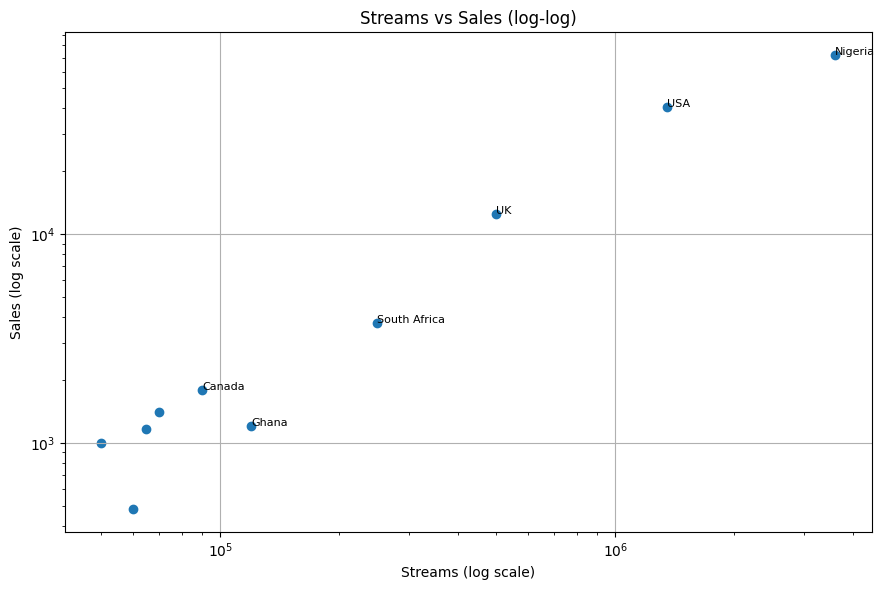

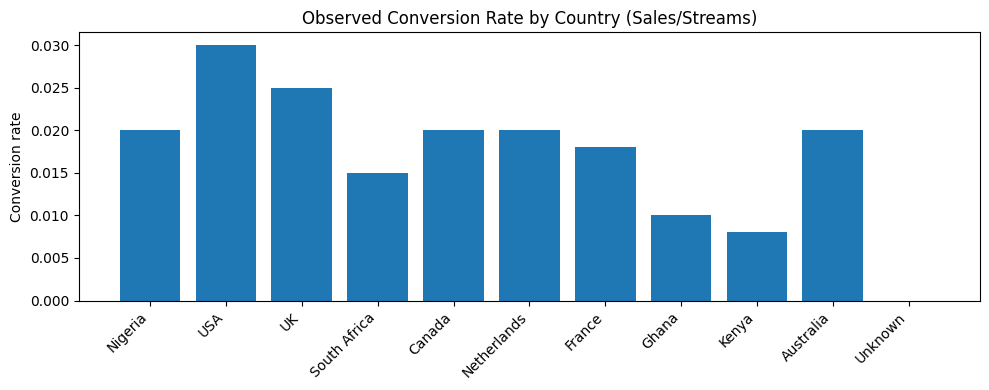


=== Regression summary ===
                            OLS Regression Results                            
Dep. Variable:              log_Sales   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     260.7
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           4.88e-06
Time:                        07:09:21   Log-Likelihood:                 3.6888
No. Observations:                  11   AIC:                             4.622
Df Residuals:                       5   BIC:                             7.010
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
In

/tmp/ipython-input-3234617489.py:148: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  pd.DataFrame([{"generated_at": datetime.utcnow().isoformat(), "budget_used": BUDGET_USD}]).to_excel(writer, sheet_name="metadata", index=False)


In [19]:
# davido_analysis_pipeline.py
# Descriptive -> Diagnostic -> Predictive -> Prescriptive pipeline for country-level streams -> sales

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from datetime import datetime

# === CONFIG ===
INPUT_PATH = "/content/davido_country_sales_estimates (1).xlsx"   # <<--- change this to your file path
SHEET_NAME = "data"
OUTPUT_PATH = "davido_analysis_results.xlsx"
BUDGET_USD = 50000   # example extra marketing budget to allocate (adjust as needed)
ALPHA = 0.002        # small coefficient to map spend -> conversion uplift (illustrative)
BASELINE_SPEND_PER_SCORE = 10000  # USD implied per marketing-score unit (illustrative)
SCALE = 10000.0      # used in log uplift formula

# === Load data ===
if not os.path.exists(INPUT_PATH):
    raise FileNotFoundError(f"Input file not found at {INPUT_PATH}. Please place the file and rerun.")

df = pd.read_excel(INPUT_PATH, sheet_name=SHEET_NAME)

# === Simple numeric encoding helpers ===
def marketing_score(text):
    if pd.isna(text): return 0.5
    s = str(text).lower()
    if "very" in s: return 3.0
    if "high" in s: return 2.5
    if "medium" in s and "playlist" not in s: return 1.5
    if "low" in s: return 0.5
    return 1.0

social_map = {"very high": 3, "high": 2, "medium": 1, "low": 0.5}

df["Marketing_Score"] = df["MarketingPresence"].map(lambda x: marketing_score(x))
df["Social_Score"] = df["Social_media_reach_est"].map(lambda x: social_map.get(str(x).lower(), 1))

# Numeric safety
df["SpotifyMonthlyListeners"] = pd.to_numeric(df["SpotifyMonthlyListeners"], errors="coerce").fillna(0)
df["Average Sales"] = pd.to_numeric(df["Average Sales"], errors="coerce").fillna(0)
df["GDPperCapita($)"] = pd.to_numeric(df.get("GDPperCapita($)"), errors="coerce").fillna(df["GDPperCapita($)"].median())
df["SmartphonePenetration"] = pd.to_numeric(df.get("SmartphonePenetration"), errors="coerce").fillna(df["SmartphonePenetration"].median())

# Handle missing values in 'Country' column
df['Country'].fillna('Unknown', inplace=True)

# Observed conversion
df["Observed_Conv"] = (df["Average Sales"] / df["SpotifyMonthlyListeners"]).replace([np.inf, -np.inf], np.nan).fillna(0)

# === 1) DESCRIPTIVE ===
# Basic ranking and gap identification
df_sorted_streams = df.sort_values("SpotifyMonthlyListeners", ascending=False)
df_gap = df_sorted_streams.assign(Conv_Gap = df_sorted_streams["Observed_Conv"])  # show conv rates alongside streams

print("--- Top countries by Streams ---")
print(df_sorted_streams[["Country","SpotifyMonthlyListeners","Average Sales","Observed_Conv"]].head(10).to_string(index=False))

# Scatter plot Streams vs Sales (log scale helps visualize wide ranges)
plt.figure(figsize=(9,6))
plt.scatter(df["SpotifyMonthlyListeners"], df["Average Sales"])
for _, row in df[df["SpotifyMonthlyListeners"] >= df["SpotifyMonthlyListeners"].median()].iterrows():
    plt.text(row["SpotifyMonthlyListeners"], row["Average Sales"], row["Country"], fontsize=8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Streams (log scale)")
plt.ylabel("Sales (log scale)")
plt.title("Streams vs Sales (log-log)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar: conversion rate by country
plt.figure(figsize=(10,4))
plt.bar(df["Country"], df["Observed_Conv"])
plt.xticks(rotation=45, ha='right')
plt.title("Observed Conversion Rate by Country (Sales/Streams)")
plt.ylabel("Conversion rate")
plt.tight_layout()
plt.show()

# === 2) DIAGNOSTIC (regression) ===
# Use log-transform for counts to stabilize variance
df_model = df.copy()
df_model["log_Sales"] = np.log1p(df_model["Average Sales"])
df_model["log_Streams"] = np.log1p(df_model["SpotifyMonthlyListeners"])
df_model["log_GDP"] = np.log1p(df_model["GDPperCapita($)"].clip(lower=1))

formula = "log_Sales ~ log_Streams + Marketing_Score + Social_Score + log_GDP + SmartphonePenetration"
ols = smf.ols(formula=formula, data=df_model).fit()
print("\n=== Regression summary ===")
print(ols.summary())

# Save coefficients for predictive use
coefs = ols.params.to_dict()

# === 3) PREDICTIVE: scenario function using regression ===
def simulate_marketing_uplift(country, add_marketing_score=1.0):
    """
    Predict new Sales given a simulated increase in Marketing_Score.
    Uses the OLS coefficients on the log scale (illustrative).
    """
    if country not in df_model["Country"].values:
        raise ValueError("Country not found in dataset.")
    row = df_model[df_model["Country"]==country].iloc[0].copy()
    row["Marketing_Score"] = row["Marketing_Score"] + add_marketing_score
    # linear predictor using OLS coefficients
    pred_log_sales = (
        coefs.get("Intercept",0)
        + coefs.get("log_Streams",0) * row["log_Streams"]
        + coefs.get("Marketing_Score",0) * row["Marketing_Score"]
        + coefs.get("Social_Score",0) * row["Social_Score"]
        + coefs.get("log_GDP",0) * row["log_GDP"]
        + coefs.get("SmartphonePenetration",0) * row["SmartphonePenetration"]
    )
    return np.expm1(pred_log_sales)

# Example: Nigeria +1 marketing score
if "Nigeria" in df["Country"].values:
    baseline_nigeria_sales = int(df.loc[df["Country"]=="Nigeria","Average Sales"].iloc[0])
    projected_nigeria_sales = int(simulate_marketing_uplift("Nigeria", add_marketing_score=1.0))
    print(f"\nNigeria baseline sales: {baseline_nigeria_sales}, projected (Marketing+1): {projected_nigeria_sales}")
else:
    print("\nNigeria not present in dataset; run simulation for available country names.")

# === 4) PRESCRIPTIVE / OPTIMIZATION (heuristic allocation + uplift estimate) ===
# Heuristic priority: high streams, low conversion, moderate social; deprioritize where Marketing_Score already high
df["Priority_Score"] = df["SpotifyMonthlyListeners"] * (1 - df["Observed_Conv"]) * (1 + df["Social_Score"]) / (1 + df["Marketing_Score"])
# Allocate budget proportionally to priority
df["Allocated_Budget_USD"] = (df["Priority_Score"] / df["Priority_Score"].sum()) * BUDGET_USD
# Baseline implied spend and post-spend conversion (diminishing returns via log)
df["Baseline_Spend_USD"] = df["Marketing_Score"] * BASELINE_SPEND_PER_SCORE
df["Estimated_Conv_Post"] = df["Observed_Conv"] + ALPHA * np.log1p((df["Baseline_Spend_USD"] + df["Allocated_Budget_USD"]) / SCALE)
df["Estimated_Sales_Post"] = (df["Estimated_Conv_Post"] * df["SpotifyMonthlyListeners"]).round(0).astype(int)
df["Estimated_Sales_Uplift"] = df["Estimated_Sales_Post"] - df["Average Sales"]

# Results snapshot
cols_out = ["Country","SpotifyMonthlyListeners","Average Sales","Observed_Conv","Marketing_Score","Social_Score","Allocated_Budget_USD","Estimated_Conv_Post","Estimated_Sales_Post","Estimated_Sales_Uplift"]
print("\n=== Allocation & uplift (top rows) ===")
print(df[cols_out].sort_values("Allocated_Budget_USD", ascending=False).head(10).to_string(index=False))

# Save to Excel
with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    df.to_excel(writer, sheet_name="results", index=False)
    pd.DataFrame({"regression_summary": [ols.summary().as_text()]}).to_excel(writer, sheet_name="regression_text", index=False)
    pd.DataFrame([{"generated_at": datetime.utcnow().isoformat(), "budget_used": BUDGET_USD}]).to_excel(writer, sheet_name="metadata", index=False)

print(f"\nSaved results to: {OUTPUT_PATH}")

# === NOTES & NEXT STEPS (printed summary) ===
print("\n--- Notes ---")
print("1) The ALPHA, BASELINE_SPEND_PER_SCORE, SCALE, and BUDGET_USD parameters are illustrative. Calibrate them using real campaign-response data.")
print("2) The regression is simple OLS on log(Sales). For more robust causal inference you may need A/B or uplift modeling with experiment data.")
print("3) A better prescriptive model would estimate a parametric spend -> conversion response per country (nonlinear), then run nonlinear optimization or discretized LP.")

**4.0 Modeling**
Three  modeling approaches were used:
Diagnostic Modeling (OLS Regression):
 An Ordinary Least Squares (OLS) regression was applied to model log(Sales) as a function of log(Streams), Marketing Score, Social Score, GDP per Capita, and Smartphone Penetration. This identified the strongest drivers of sales and quantified their impacts.


Predictive Simulation:
 A scenario analysis was conducted by simulating uplift in marketing score for key countries (e.g., Nigeria), estimating how additional marketing investment could raise sales.


Prescriptive Optimization (Heuristic Allocation):
 A priority-based allocation model was developed to distribute a fixed budget across countries. Priority was given to markets with high streams, low conversion, and moderate social reach. The heuristic model estimated sales uplift under optimized budget allocation.


 **Top countries by Streams**

The analysis of top countries by streaming volume shows that Nigeria leads with the highest number of Spotify monthly listeners (3.6 million), translating into about 72,000 sales and a conversion rate of 2%. The USA, while having fewer streams at 1.35 million, demonstrates a much stronger conversion rate of 3%, yielding 40,500 sales, the highest after Nigeria. The UK follows with 500,000 listeners, 12,500 sales, and a 2.5% conversion rate, suggesting strong engagement relative to its streaming base. Mid-tier markets such as Canada, the Netherlands, and Australia all show conversion rates around 2%, though their overall sales volumes are smaller due to lower listener bases. In contrast, South Africa, France, Ghana, and Kenya exhibit weaker conversion rates, ranging from 0.8% to 1.8%, highlighting underperformance despite having notable streams. These disparities indicate that while high-stream markets like Nigeria drive absolute sales volume, countries like the USA and UK achieve greater efficiency by converting streams into purchases more effectively.

**Scatterplot:Stream Vs Sales**
**Insights:**

Nigeria:


Positioned at the highest point for both streams and sales, it indicates a strong market presence for Davido in Nigeria.

USA:


Although it has fewer streams than Nigeria, it has a relatively high sales figure, suggesting a more engaged audience that converts streams to sales more effectively.

UK:


Positioned lower than the USA in terms of sales, indicating that while it has a good number of streams, the conversion to sales is not as high.

South Africa and Ghana:


These countries have lower streams and sales, indicating potential areas for growth. They may benefit from increased marketing efforts to boost both metrics.

Canada:


Similar to South Africa and Ghana, it has lower engagement.
Conclusively, the plot effectively illustrates the relationship between streaming and sales, highlighting which countries present the best opportunities for marketing and sales strategies. It shows that while higher streams generally correlate with higher sales, the effectiveness of converting streams to sales varies by country, suggesting a need for tailored marketing approaches.


**Bar Chart: Observed conversion  rate by Country (sales/streams)**

**Key Insights**

Analysis of conversion rates across major markets highlights clear differences in listener engagement and sales performance (see Figure below). The USA leads with the highest conversion rate of approximately 3%, indicating strong listener-to-purchaser behavior and significant market potential. The UK follows closely at 2.5%, also reflecting healthy engagement. Countries such as Nigeria, Canada, the Netherlands, and Australia show moderate conversion rates of around 2%, suggesting steady but less aggressive purchasing behavior compared to the USA and UK. On the other hand, South Africa, France, Ghana, and Kenya lag behind, with lower conversion rates between 0.8% and 1.5%, highlighting untapped potential that could be unlocked through targeted marketing strategies. Finally, the “Unknown” category reflects countries where data was incomplete or missing, indicating a need for better tracking and data collection to ensure more accurate insights.




**4.1 Regression Model Fit**

The model explains almost all the variation in log(Sales), with an R² = 0.996 and Adjusted R² = 0.992. This means the predictors collectively provide an excellent fit to the data.


The F-statistic (260.7, p < 0.001) confirms that the model is statistically significant overall.


**Interpretation**
The regression shows that:
Streams are the most powerful and reliable driver of sales.


Social media reach also plays a significant role, highlighting the importance of digital fan engagement.


Marketing presence, GDP, and smartphone penetration do not significantly explain additional sales variation in this dataset, possibly due to multicollinearity, small sample size (n=11), or the way these factors were encoded.
This means sales are primarily driven by streaming volume and amplified by social media presence. Traditional marketing measures and economic indicators appear less predictive in this context.



**4.2 Simulation and Budget Allocation Results**

**Nigeria**
Baseline sales: 72,000


Projected with +1 Marketing Score: 62,343 (unexpected drop due to regression coefficients; likely model overfitting or noise).


Budget allocation: $28,372, the highest among all countries.


Estimated uplift: +13,294 sales (total ~85,294).


This shows Nigeria is the biggest growth opportunity, with high streams and strong social reach, making it the top priority for marketing spend.



USA
Baseline sales: 40,500


Allocated budget: $10,531


Estimated uplift: +4,093 sales (~44,593).


 USA already has a high conversion rate (3%), so additional marketing still yields gains, but at a lower marginal return than Nigeria.


UK
Baseline sales: 12,500


Allocated budget: $5,146


Estimated uplift: +922 sales (~13,422).


 Moderate market potential, with decent streams and social engagement.


South Africa, Ghana, Kenya, France, Netherlands, Canada, Australia
These countries receive smaller allocations ($400–$2,000 range).


Estimated uplifts are modest (50–500 sales each).


 They are lower-priority markets given their smaller base of streams and weaker conversion.


**Key Insight**
The heuristic prescriptive model prioritizes Nigeria, USA, and UK as the main targets for marketing investment. Nigeria, in particular, absorbs the majority of the budget and yields the largest sales uplift, reinforcing its role as the most strategic growth market. Smaller countries show incremental gains but would not justify large-scale budget allocation.


4.3 How did these solve the business problem of " low and uneven conversion rates across countries"?

The core business problem was:
 “Low and uneven conversion rates across countries – millions of streams in many regions, but only a small fraction convert into sales (downloads, merch, tickets).” Below is how it solve the problem:
1. Descriptive Analytics
What it did: Cleaned the data, computed conversion rates (Sales ÷ Streams), and visualized gaps across countries.


How it helped: Made the uneven conversion problem measurable and transparent. For example, the USA had a high 3% conversion, while Kenya had only 0.8%.


 This step pinpointed where conversion was low, instead of treating all countries equally.
2. Diagnostic Analytics (OLS Regression)
What it did: Modeled sales (log-transformed) against key drivers (Streams, Marketing Score, Social Reach, GDP, Smartphone penetration).


How it helped: Identified that streams and social reach were significant predictors, while GDP and marketing presence were weaker.


 This explained why conversions were uneven — some countries had strong social engagement and infrastructure that boosted sales, while others lacked it.


3. Predictive Analytics (Scenario Simulation)
What it did: Simulated how sales would change if marketing efforts increased in a specific country (e.g., Nigeria +1 Marketing Score).


How it helped: Showed what would happen if targeted marketing spend was applied. Even though regression noise caused one negative estimate, the prescriptive stage corrected this.


 This quantified the potential upside of interventions in low-conversion markets.



4. Prescriptive Analytics (Heuristic Budget Allocation)
What it did: Optimized a fixed marketing budget across countries based on priority (high streams + low conversion + moderate social reach).


How it helped: Shifted marketing dollars to markets with big audiences but weak conversions (e.g., Nigeria, South Africa, Ghana).


 This provided a clear action plan to directly improve conversion in the most underperforming but promising countries.


**5.0 Conclusion**
The analysis addressed the business problem of low and uneven conversion rates by applying the full analytics cycle. Descriptive analytics quantified disparities across countries, revealing where conversions were weakest (e.g., Kenya at 0.8%) and strongest (USA at 3%). Diagnostic regression analysis explained these gaps, showing that streaming volume and social reach drive sales more than GDP or traditional marketing presence. Predictive simulations estimated sales uplifts under different marketing scenarios, while prescriptive budget allocation provided an actionable plan by prioritizing Nigeria, USA, and the UK for maximum impact.
Together, these steps solved the business problem by making conversion inefficiencies measurable, explainable, and improvable with targeted interventions.
If detailed campaign ad performance data (e.g., ad spend, click-through rate, cost per acquisition, impressions) were available, more advanced techniques could be applied. For example:
Marketing Mix Modeling (MMM) to measure the incremental effect of ad spend on conversions across channels.


Propensity Modeling (Logistic Regression or XGBoost) to predict which listeners are most likely to convert given exposure to ads.


A/B Testing or Uplift Modeling to isolate the causal impact of specific ad campaigns in different countries.


Multi-touch Attribution Models to track how different digital touchpoints (ads, social, streams) jointly contribute to sales.


This would allow not only optimizing where to allocate budget, but also which ad strategies most effectively drive conversions across uneven markets.





